Upload dataset to colab

In [11]:
from google.colab import files
uploaded = files.upload()

In [12]:
import io
import pandas as pd
df = pd.read_csv('FoDS-A1.csv')
df = df.sample(frac = 1)

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [14]:
df

,Strength,Temperature,Pressure
720,26.6,210,10
1001,22.4,220,14
1064,27.5,240,14
1046,37.3,300,18
145,25.5,210,10
...,...,...,...
1534,23.5,210,14
1344,19.5,200,16
446,34.2,250,10
468,45.8,290,10


Normalising the values

In [15]:
df=(df-df.mean())/df.std()
df

,Strength,Temperature,Pressure
720,-0.460066,-1.264528,-1.463406
1001,-1.028382,-0.948396,-0.292681
1064,-0.338284,-0.316132,-0.292681
1046,0.987788,1.580660,0.878044
145,-0.608911,-1.264528,-1.463406
...,...,...,...
1534,-0.879537,-1.264528,-0.292681
1344,-1.420791,-1.580660,0.292681
446,0.568317,0.000000,-1.463406
468,2.137953,1.264528,-1.463406


70-30 train-test split

In [16]:
train_data = df.iloc[:1155]
test_data = df.iloc[1155:]

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

s_train = train_data[:,[0]]
t_train = train_data[:,[1]] 
p_train = train_data[:,[2]]

s_test = test_data[:,[0]]
t_test = test_data[:,[1]] 
p_test = test_data[:,[2]]

In [17]:
def generateValuesMatrix(req_deg, S, T, P):
  n = S.shape[0]
  data_points = np.ones(n, dtype = np.float64).reshape(-1,1)
  i = 1
  while(i <= req_deg):
      length = (int)((i+1)*(i)/2)
      temp = data_points[:, length-i:]
      temp = temp * S
      data_points = np.concatenate((data_points, temp, pow(T, i)), axis = 1)
      i = i + 1
  data_points = np.concatenate((data_points, (-1)*P), axis=1)
  return data_points

In [28]:
def input_function():
  degree = int(input("Enter the required degree: "))
  isStochastic = bool(int(input("Which Algorithm:\n0. Normal Gradient Descent\n1. Stochastic Gradient Descent\n")))
  regularisation = int(input("Type of regularisation required:\n0. No regularisation\n1. Lasso\n2. Ridge\n"))
  la = 0
  if regularisation != 0:
    la = float(input("Lambda for regularisation: "))
  iterations = int(input("Number of iterations: "))
  learningRate = float(input("Learning rate(Eta): "))
  return (degree, isStochastic, regularisation, iterations, learningRate, la)

In [36]:
def plotting_function(degree, coefficients):
  # Creating dataset
  x = np.outer(np.linspace(s_train.min(), s_train.max(), 100), np.ones(100))
  y = np.outer(np.linspace(t_train.min(), t_train.max(), 100), np.ones(100)).T
  i = 1
  j = 1
  z = coefficients[0][0]*pow(x,0)*pow(y,0)
  while i <= degree:
    temp = i
    while temp >= 0:
      z = z + coefficients[j][0] * pow(x, temp) * pow(y, i - temp)
      temp=temp-1
      j = j + 1
    i=i+1

  print(j)
  
  # Creating figure
  fig = plt.figure(figsize =(14, 9))
  ax = plt.axes(projection ='3d')

  # creating plot 
  ax.scatter3D(s_train, t_train, p_train, color = 'red')
  ax.plot_surface(x,y,z,color='green')
  
  # show plot
  plt.show()

In [40]:
def gradientDescent():
  req_deg, isStochastic, regularisation, no_of_iterations, eta, la = input_function()
  data_train = generateValuesMatrix(req_deg, s_train, t_train, p_train)
  data_test = generateValuesMatrix(req_deg, s_test, t_test, p_test)
  n_coeffs = (req_deg + 1) * (req_deg + 2) // 2
  coeffecients = np.ones(n_coeffs+1).reshape(-1,1) # Initializing coefficient matrix
  coeffecients[n_coeffs] = 1 # To consider the pressure value
  trainingerror = 1000000 # garbage value
  testingerror = 10000000 # garbage value
  for _ in range(no_of_iterations):
      
      # Matrix Multiplying coeffcients with data points
      if isStochastic:
        inde = randint(0, 1154)
        intermediate_matrix = data_train[inde,:].dot(coeffecients)
      else:
        intermediate_matrix = data_train.dot(coeffecients)

      if(_ % 50) == 0:
          training_error = intermediate_matrix * intermediate_matrix
          if isStochastic:
            temp = data_train.dot(coeffecients)
            training_error = temp * temp
          inter_test = data_test.dot(coeffecients)
          testing_error = inter_test * inter_test
          new_train = training_error.sum()
          new_test = testing_error.sum()
          if new_train < trainingerror:
            trainingerror = new_train
          if new_test < testingerror:
            testingerror = new_test
          print(f"(Training, Testing) error  for {_}th iteration is ({new_train}, {new_test})")
      slope = np.zeros(n_coeffs)
      la_matrix = np.zeros(n_coeffs)
      j = 0
      while(j < n_coeffs):
          if isStochastic:
            slope[j] = float((intermediate_matrix*data_train[inde, [j]]).sum())
          else:
            slope[j] = float((intermediate_matrix*data_train[:, [j]]).sum())
          la_matrix[j] = ( abs(coeffecients[j][0]) / coeffecients[j][0] )*float(la)
          j = j+1
      slope = slope.reshape(-1,1) # Making it a column
      la_matrix = la_matrix.reshape(-1,1)

      if regularisation == 2: # regularisation = 2 for ridge regression
        slope = slope + (la_matrix*coeffecients[:-1, :])          
      elif regularisation == 1: # regularisation = 1 for lasso regression
        slope = slope + la_matrix
      # regularisation = 0 for no regularisation

      coeffecients[:-1, :] = coeffecients[:-1, :] - (eta)*slope # Gradient Descent Formula
  print(coeffecients)
  print(trainingerror, testingerror)
  plotting_function(degree=req_deg, coefficients=coeffecients)
  return coeffecients

Enter the required degree: 0
Which Algorithm:
0. Normal Gradient Descent
1. Stochastic Gradient Descent
1
True
Type of regularisation required:
0. No regularisation
1. Lasso
2. Ridge
0
Number of iterations: 10000
Learning rate(Eta): 0.001
(Training, Testing) error  for 0th iteration is (2261.799949003014, 1037.2000509969866)
(Training, Testing) error  for 50th iteration is (2195.419490108986, 1006.5804185610366)
(Training, Testing) error  for 100th iteration is (2111.3605059895635, 967.7039420461331)
(Training, Testing) error  for 150th iteration is (2048.2394107742202, 938.4274625318319)
(Training, Testing) error  for 200th iteration is (1974.753949773793, 904.242072813474)
(Training, Testing) error  for 250th iteration is (1876.1150057610535, 858.1572224733776)
(Training, Testing) error  for 300th iteration is (1818.477993442809, 831.1067946993246)
(Training, Testing) error  for 350th iteration is (1777.2268923530291, 811.683159090936)
(Training, Testing) error  for 400th iteration i

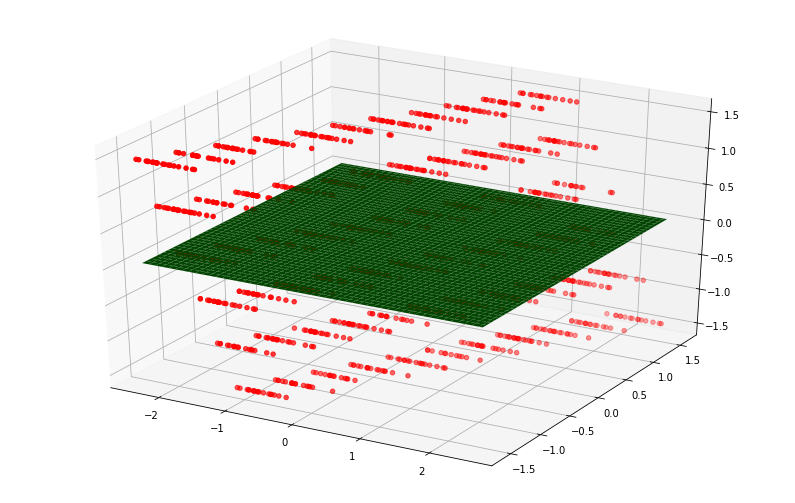

array([[0.05303808],
       [1.        ]])

In [41]:
gradientDescent()